# Seismic Waves

Seismic waves are elastic waves in the Earth (or other planetary body). Seismic waves are
generally separating into body waves and surface waves.  Body waves travel through the solid Earth,
surface waves occur at boundaries (most noticeably the Earth's free surface).

- P waves (equations)
- S waves (equations)
- Surface waves (equations) - talk about guided waves

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Makes plots work well with dark theme

Lets look at some of the complexity that we can see in seismograms, then think about what we see.
We will download some data from a seismograph in Hawaii that recorded a deep focus, large magnitude
earthquake near Tonga. Details for this event can be found on the IRIS website 
[here](http://ds.iris.edu/ds/nodes/dmc/tools/event/10944928).

In [2]:
from obspy.clients.fdsn import Client

event_id = "10944928"

client = Client("IRIS")
catalog = client.get_events(eventid=event_id)
print(catalog)

1 Event(s) in Catalog:
2018-09-06T15:49:14.420000Z | -18.495, +179.356 | 7.9 mww


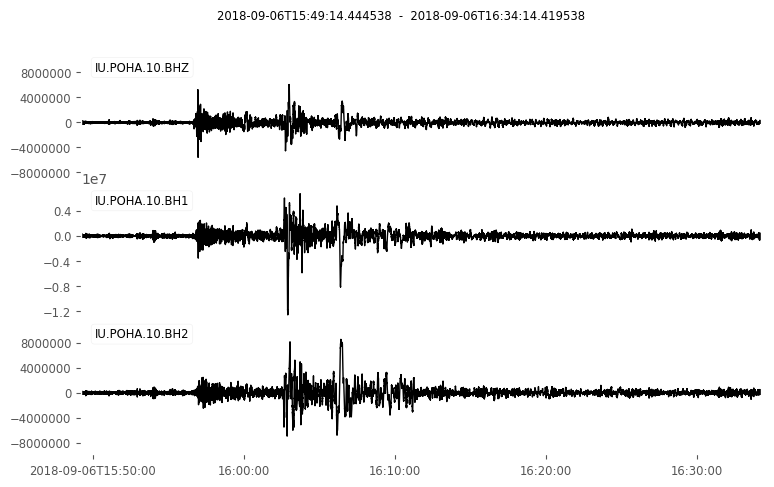

In [3]:
event = catalog[0]
st = client.get_waveforms(
    network="IU", station="POHA", channel="BH?", location="10",
    starttime=event.preferred_origin().time,
    endtime=event.preferred_origin().time + (45 * 60))
fig = st.plot(size=(800, 500))

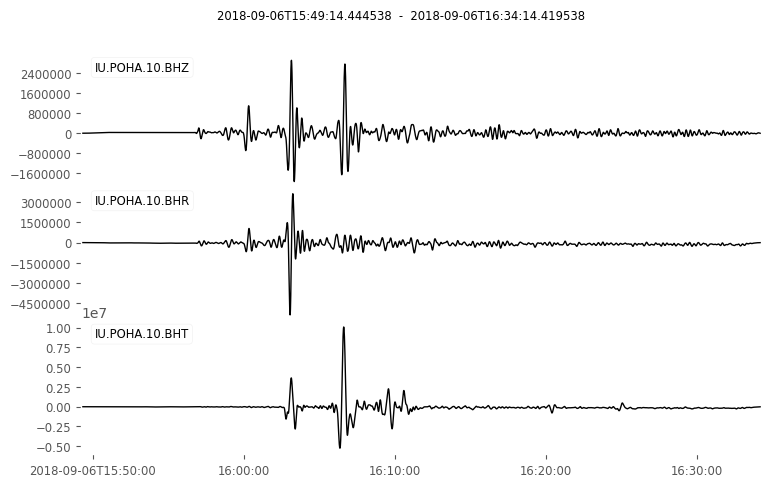

In [4]:
from obspy.geodetics import gps2dist_azimuth

inv = client.get_stations(
    network=st[0].stats.network, station=st[0].stats.station,
    startbefore=st[0].stats.starttime, endafter=st[0].stats.endtime,
    level="response")
network = inv[0]
station = network[0]
dist, az, baz = gps2dist_azimuth(
    lat1=event.preferred_origin().latitude,
    lon1=event.preferred_origin().longitude,
    lat2=station.latitude, lon2=station.longitude)
# Rotate first to ZNE, then to radial and transverse
st.rotate(method="->ZNE", inventory=inv)
st.rotate(method="NE->RT", back_azimuth=baz)

st_filtered = st.copy().detrend().taper(
    max_length=100, max_percentage=20).filter(
    'lowpass', freq=0.05, corners=4)

fig = st_filtered.plot(size=(800, 500), equal_scale=False)

/home/calumch/miniconda3/envs/conda_36/lib/python3.6/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


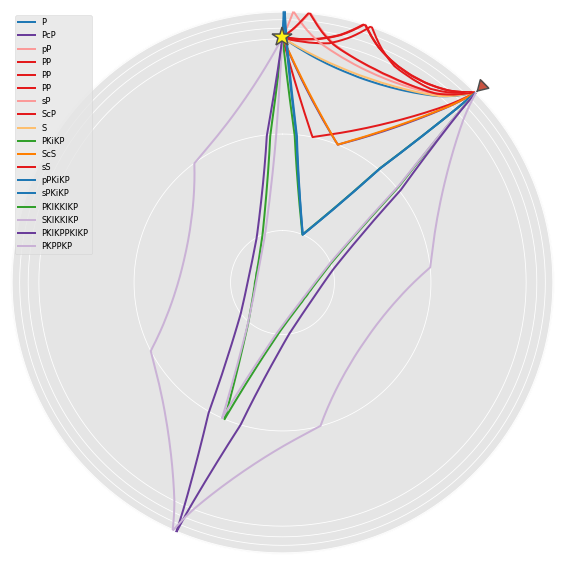

In [5]:
# To Do: calculate expected arrivals from obspy TauP toolbox - plot rays and arrivals on seismogram
from obspy.taup import TauPyModel

model = TauPyModel(model='ak135')
arrivals = model.get_ray_paths_geo(
    source_depth_in_km=event.preferred_origin().depth / 1000,
    source_latitude_in_deg=event.preferred_origin().latitude,
    source_longitude_in_deg=event.preferred_origin().longitude,
    receiver_latitude_in_deg=station.latitude,
    receiver_longitude_in_deg=station.longitude,
    phase_list=["ttbasic"])
fig = plt.figure(figsize=(10, 10))
fig = arrivals.plot_rays(plot_type='spherical', legend=True, fig=fig)

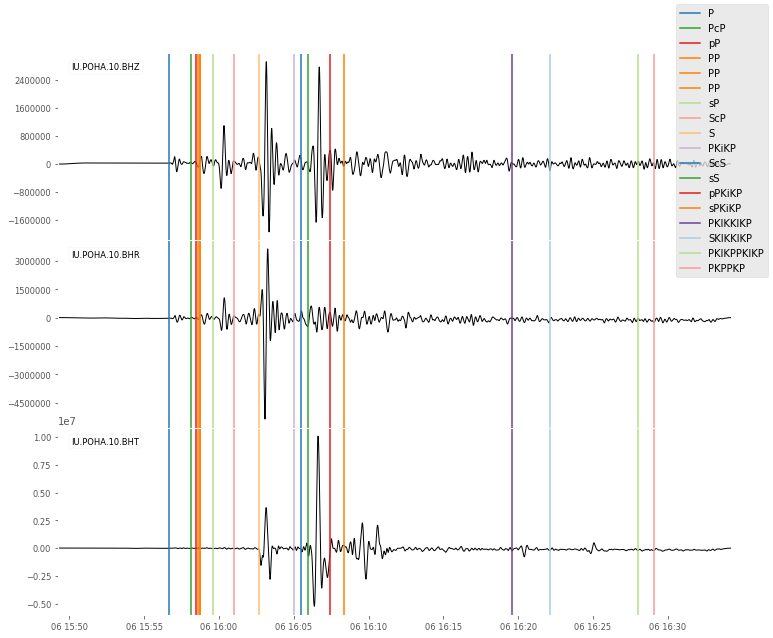

In [6]:
from obspy.taup.tau import COLORS

fig = plt.figure(figsize=(11, 9))
fig = st_filtered.plot(equal_scale=False, fig=fig)
axes = fig.axes
phase_names = [arrival.name for arrival in arrivals]
for ax in axes:
    for arrival in arrivals:
        if ax == axes[0]:
            label = arrival.name
        else:
            label = None
        ax.axvline(x=(event.preferred_origin().time + arrival.time).datetime,
                   color=COLORS[phase_names.index(arrival.name) % len(COLORS)],
                   label=label)
_ = fig.legend()